# Lab 3: Clustering

## AirBnB Listings for Los Angeles Area

### Jason McDonald, Miguel Bonilla, Zachary Bunn

**Table of Contents**
- [Business Understanding](#Business-Understanding)
- [Data Understanding 1](#Data-Understanding-1)
    - [Data Wrangling](#Data-Wrangling)
        - [Missing Values](#Missing-Values)
        - [Duplicates](#Duplicates)
        - [Outliers](#Outliers)
- [Data Understanding 2](#Data-Understanding-2)
- [Modeling and Evaluation 1](#Modeling-and-Evaluation-1)
    - [Prepare Data](#Prepare-Data)
        - [One-Hot Encoding](#One-Hot-Encoding)
        - [Scaling](#Scaling)
    - [K-Means](#K-Means)
    - [Affinity Propagation](#Affinity-Propagation)
    - [Bisecting K-Means](#Bisecting-K-Means)
    - [DBSCAN](#DBSCAN)
    - [Agglomerative Clustering](#Agglomerative-Clustering)
- [Modeling and Evaluation 2](#Modeling-and-Evaluation-2)
- [Modeling and Evaluation 3](#Modeling-and-Evaluation-3)
- [Modeling and Evaluation 4](#Modeling-and-Evaluation-4)

In [16]:
# Import Packages
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
import scipy
from sklearnex import patch_sklearn, unpatch_sklearn

### Business Understanding
(10 Points) Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). How will you measure the effectiveness of a good algorithm? Why does your chosen validation method make sense for this specific
dataset and the stakeholders needs?

### Data Understanding 1
(10 Points) Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file. Verify data quality: Are there missing values? Duplicate data? Outliers? Are those mistakes? How do you deal with these problems?

#### Data Wrangling

In [2]:
# load the data
df = pd.read_csv("Data_Files/airbnb_los_angeles.csv")

In [3]:
# Remove non-useful variables
for col in [
    'listing_url','scrape_id','last_scraped','description','neighborhood_overview','picture_url','host_url','host_about','host_response_time','host_response_rate','host_acceptance_rate',
    'host_thumbnail_url','host_picture_url','host_verifications','host_has_profile_pic','bathroom_text','host_listings_count','host_neighbourhood','bathrooms','minimum_minimum_nights',
    'maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm','calendar_updated','availability_30','availability_60',
    'availability_90','availability_365','calendar_last_scraped','number_of_reviews_ltm','number_of_reviews_l30d','review_scores_accuracy','review_scores_communication','review_scores_cleanliness',
    'review_scores_checkin','review_scores_value','review_scores_location','calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms',
    'calculated_host_listings_count_shared_rooms','reviews_per_month','neighbourhood','neighbourhood_group_cleansed', 'first_review','last_review','minimum_nights','maximum_nights','license','host_total_listings_count'
]:
    if col in df:
        del df[col]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42041 entries, 0 to 42040
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              42041 non-null  int64  
 1   name                            42039 non-null  object 
 2   host_id                         42041 non-null  int64  
 3   host_name                       41858 non-null  object 
 4   host_since                      41858 non-null  object 
 5   host_location                   41780 non-null  object 
 6   host_is_superhost               41858 non-null  object 
 7   host_identity_verified          41858 non-null  object 
 8   neighbourhood_cleansed          42041 non-null  object 
 9   latitude                        42041 non-null  float64
 10  longitude                       42041 non-null  float64
 11  property_type                   42041 non-null  object 
 12  room_type                       

##### Missing Values
After removing unusable varialbes, we are left with 24 variables (14 categorical, 10 numerical).
10 variables have missing values (name, host_name, host_since, host_location, host_is_superhost, host_identity_verified, bathrooms_text, bedrooms, beds, and review_scores_rating)

In [4]:
# remove nulls
df = df[~df.review_scores_rating.isnull() & ~df.bathrooms_text.isnull() & ~df.host_since.isnull() & ~df.host_location.isnull()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32329 entries, 0 to 42000
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32329 non-null  int64  
 1   name                            32329 non-null  object 
 2   host_id                         32329 non-null  int64  
 3   host_name                       32329 non-null  object 
 4   host_since                      32329 non-null  object 
 5   host_location                   32329 non-null  object 
 6   host_is_superhost               32329 non-null  object 
 7   host_identity_verified          32329 non-null  object 
 8   neighbourhood_cleansed          32329 non-null  object 
 9   latitude                        32329 non-null  float64
 10  longitude                       32329 non-null  float64
 11  property_type                   32329 non-null  object 
 12  room_type                       

In [5]:
## Creating categorical variable property type from string
types = ['Private room', 'Entire', 'Room in hotel','Room','Shared room']
pat = '|'.join(r"\b{}\b".format(x) for x in types)

df['property_type']= df['property_type'].str.extract('('+ pat + ')', expand = False)
df['property_type'] = (df.property_type.
                       fillna(value = 'other').
                       replace(['Entire','Room in hotel'],['Entire unit','Hotel room']))
df['property_type'].value_counts()

Entire unit     22767
Private room     8081
Shared room       510
Room              401
other             298
Hotel room        272
Name: property_type, dtype: int64

In [6]:
# impute values based on median
df['beds'] = df[['accommodates','beds']].groupby(by = 'accommodates').transform(lambda grp: grp.fillna(grp.median()))
df_grouped = df.groupby(by = ['property_type','beds'])
df_imputed = df_grouped[['beds','bedrooms']].transform(lambda grp: grp.fillna(grp.median()))

index = df_imputed[df_imputed.bedrooms.isnull()].index
df = df.drop(index= index)

df['imputed']=df_imputed[['bedrooms']]

# replace 'bedrooms' column with imputed column and deleting the duplicated column
df['bedrooms'] = df['imputed']
del df['imputed']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32327 entries, 0 to 42000
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32327 non-null  int64  
 1   name                            32327 non-null  object 
 2   host_id                         32327 non-null  int64  
 3   host_name                       32327 non-null  object 
 4   host_since                      32327 non-null  object 
 5   host_location                   32327 non-null  object 
 6   host_is_superhost               32327 non-null  object 
 7   host_identity_verified          32327 non-null  object 
 8   neighbourhood_cleansed          32327 non-null  object 
 9   latitude                        32327 non-null  float64
 10  longitude                       32327 non-null  float64
 11  property_type                   32327 non-null  object 
 12  room_type                       

We can see that all missing values have been properly dealth with. After imputation, there are no missing values left in the dataset.

In [7]:
## fixing variable types
df['host_since'] = pd.to_datetime(df.host_since)
df['price'] = df['price'].replace('[\$,]','',regex = True).astype(float)
df['bathrooms_text'] = df['bathrooms_text'].replace(['Half-bath', 'Shared half-bath', 'Private half-bath'],['0.5 bath','0.5 shared bath', '0.5 private bath'])
df_bathrooms = df['bathrooms_text'].str.split(n=1, expand=True).rename(columns = {0:'bathroom_number',1:'bathroom_type'})
df_bathrooms['bathroom_type'] = df_bathrooms.bathroom_type.fillna(value = 'bath')
df_bathrooms['bathroom_type'] = df_bathrooms['bathroom_type'].replace(['baths','shared baths'],['bath','shared bath'])
df_bathrooms['bathroom_number'] = df_bathrooms['bathroom_number'].astype('float')
df.insert(15, 'bathroom_number',df_bathrooms['bathroom_number'])
df.insert(16, 'bathroom_type', df_bathrooms['bathroom_type'])
del df['bathrooms_text']

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32327 entries, 0 to 42000
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              32327 non-null  int64         
 1   name                            32327 non-null  object        
 2   host_id                         32327 non-null  int64         
 3   host_name                       32327 non-null  object        
 4   host_since                      32327 non-null  datetime64[ns]
 5   host_location                   32327 non-null  object        
 6   host_is_superhost               32327 non-null  object        
 7   host_identity_verified          32327 non-null  object        
 8   neighbourhood_cleansed          32327 non-null  object        
 9   latitude                        32327 non-null  float64       
 10  longitude                       32327 non-null  float64       
 11  pr

##### Duplicates

In [9]:
df.nunique()

id                                32327
name                              31649
host_id                           17749
host_name                          6802
host_since                         4132
host_location                      1011
host_is_superhost                     2
host_identity_verified                2
neighbourhood_cleansed              303
latitude                          23511
longitude                         25476
property_type                         6
room_type                             4
accommodates                         16
bathroom_number                      25
bathroom_type                         3
bedrooms                             13
beds                                 23
amenities                         30619
price                              1424
has_availability                      2
number_of_reviews                   577
review_scores_rating                167
instant_bookable                      2
calculated_host_listings_count       73


The unique indentifier 'id' shows no duplicates. Therefore we can assume no two listings are the same. Since each individual listing is unique.

##### Outliers

In [10]:
df.iloc[:,[13,14,16,17,19,21,22,24]].describe().T

count        mean         std   min    25%  \
accommodates                    32327.0    4.043926    2.832425   1.0   2.00   
bathroom_number                 32327.0    1.547963    0.994749   0.0   1.00   
bedrooms                        32327.0    1.746791    1.116748   1.0   1.00   
beds                            32327.0    2.264083    1.738420   1.0   1.00   
price                           32327.0  256.995824  458.488392  10.0  89.00   
number_of_reviews               32327.0   46.673493   79.700341   1.0   4.00   
review_scores_rating            32327.0    4.699717    0.617229   0.0   4.67   
calculated_host_listings_count  32327.0   13.376744   44.445160   1.0   1.00   

                                   50%    75%      max  
accommodates                      3.00    6.0     16.0  
bathroom_number                   1.00    2.0     12.0  
bedrooms                          1.00    2.0     17.0  
beds                              2.00    3.0     30.0  
price                           149.00  275.0  15636.0  
number_of_reviews                15.00   53.0   1512.0  
review_scores_rating              4.88    5.0      5.0  
calculated_host_listings_count    2.00    7.0    532.0

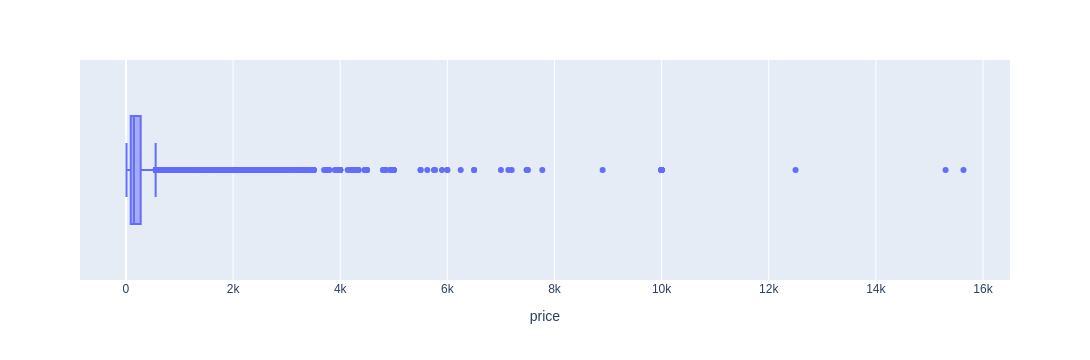

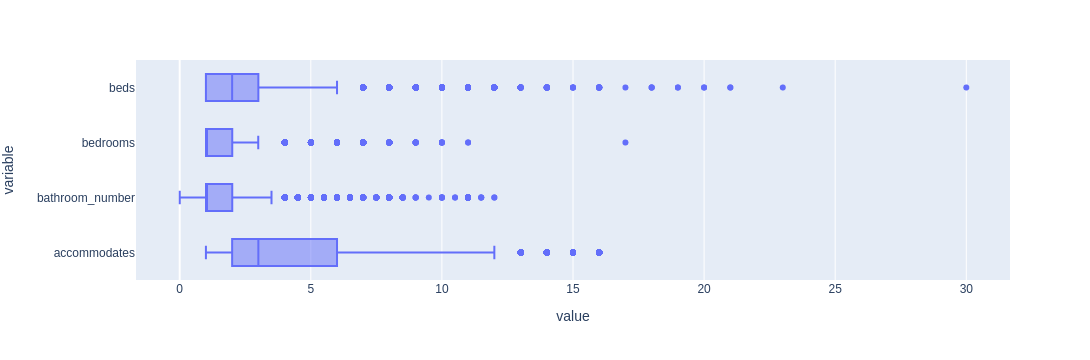

In [11]:
fig1 = px.box(df, x='price')
fig2 = px.box(df, x= ['accommodates','bathroom_number', 'bedrooms','beds',])
fig1.show()
fig2.show()

We can clearly see that price has extreme outliers, with the 75% percentile at \\$275, and listing prices at up to \\$1500. Therefore, it was decided to filter out listings with prices of \\$750 and above, to maintain some insight into luxury listings. This also handles some of the most extreme outliers for bedrooms and bathroom_number.

In [12]:
### filter out price outliers
df = df[(df.beds<10) & (df.price<750)]
df = df.reset_index(drop=True)

In [13]:
# breakdown of categorical variables with number of levels (unique)
df.iloc[:,[1,3,5,6,7,8,11,12,15,18,20,23]].describe().T

count unique  \
name                    30580  29942   
host_name               30580   6604   
host_location           30580    980   
host_is_superhost       30580      2   
host_identity_verified  30580      2   
neighbourhood_cleansed  30580    302   
property_type           30580      6   
room_type               30580      4   
bathroom_type           30580      3   
amenities               30580  28937   
has_availability        30580      2   
instant_bookable        30580      2   

                                                                      top  \
name                                                      Boutique Hostel   
host_name                                                           David   
host_location                      Los Angeles, California, United States   
host_is_superhost                                                       f   
host_identity_verified                                                  t   
neighbourhood_cleansed                                         Long Beach   
property_type                                                 Entire unit   
room_type                                                 Entire home/apt   
bathroom_type                                                        bath   
amenities               ["Hangers", "First aid kit", "Heating", "Fire ...   
has_availability                                                        t   
instant_bookable                                                        f   

                         freq  
name                       46  
host_name                 249  
host_location           10613  
host_is_superhost       20236  
host_identity_verified  26080  
neighbourhood_cleansed   1163  
property_type           21090  
room_type               21433  
bathroom_type           22738  
amenities                  40  
has_availability        28785  
instant_bookable        19767

### Data Understanding 2
(10 Points) Visualize the any important attributes appropriately. Important: Provide an interpretation for any charts or graphs.

In [123]:
def plotCategoricalFeatures(feature1, feature1Label, feature2, feature2Label, feature3, feature3Label, titleText):
    
    fig=go.Figure()
    fig = (px.histogram(
            x=feature1,
            color=feature2,
            pattern_shape=feature3,
            color_discrete_sequence=['#00A699', '#a9a9a9', '#009477'],
            barmode="relative",
            text_auto=True,
            hover_data=[feature2, feature3]
        )
        .update_traces(
            hovertemplate = '<b>'+ feature1Label + ': </b>%{x}<br><b>Count:</b>%{y}'
            #hovertemplate = '<b>'+ feature1Label + ': </b>%{x}<b><br>' + feature2Label + ': </b>%{hoverdata[0]}<b><br>' + feature3Label + ': </b>%{customdata[1]}<br><b>Count:</b>%{y}'
        )
        .update_layout(
            title={
                "text":'<b>' + titleText + '</b>', 
                "x":0.5,},
            yaxis_title="Count",
            legend_title_text=feature2Label + ", " + feature3Label
        )
        .update_xaxes(
            categoryorder="category ascending"
        )
    )
    #print(fig)
    return fig

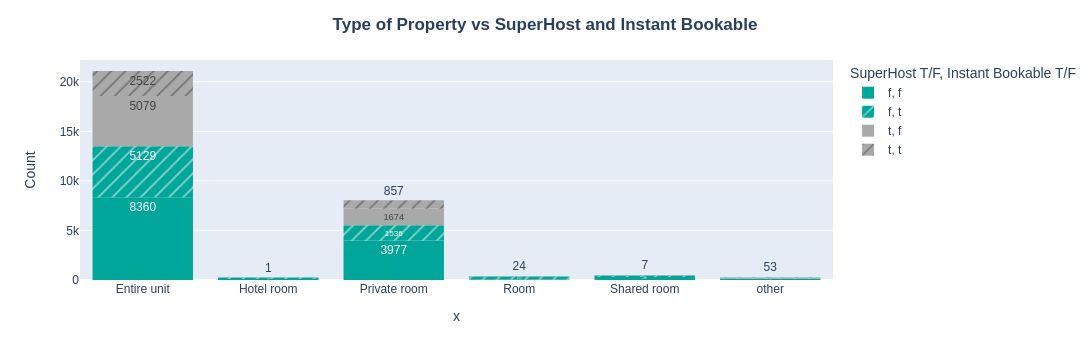

In [125]:
plotCategoricalFeatures(df['property_type'], "Property Type", df['host_is_superhost'], "SuperHost T/F", df['instant_bookable'], "Instant Bookable T/F", "Type of Property vs SuperHost and Instant Bookable").show()

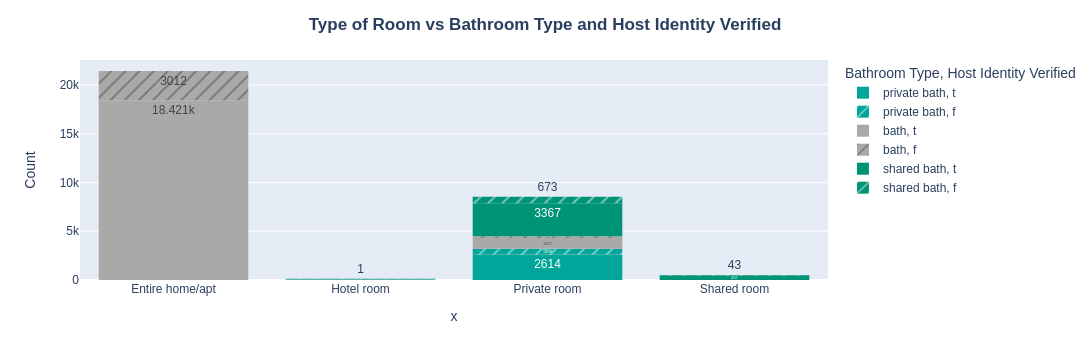

In [126]:
plotCategoricalFeatures(df['room_type'], "Room Type", df['bathroom_type'], "Bathroom Type", df['host_identity_verified'], "Host Identity Verified", "Type of Room vs Bathroom Type and Host Identity Verified").show()

### Modeling and Evaluation 1
(10 Points) Train and adjust parameters

#### Prepare Data

##### One Hot Encoding

In [14]:
label_encoder = LabelEncoder()
df['host_is_superhost'] = label_encoder.fit_transform(df['host_is_superhost'])
print('host_is_superhost')
df.host_is_superhost.value_counts()

host_is_superhost


0    20236
1    10344
Name: host_is_superhost, dtype: int64

In [15]:
## encoding binary categorical variables
# encode identity verified
df['host_identity_verified'] = label_encoder.fit_transform(df['host_identity_verified'])
print('host_identity_verified')
print(df.host_identity_verified.value_counts())

#encode has_availability
df['has_availability'] = label_encoder.fit_transform(df['has_availability'])
print('has_availability')
print(df.has_availability.value_counts())

#encode instant bookable
df['instant_bookable'] = label_encoder.fit_transform(df['instant_bookable'])
print('instant_bookable')
print(df.instant_bookable.value_counts())

host_identity_verified
1    26080
0     4500
Name: host_identity_verified, dtype: int64
has_availability
1    28785
0     1795
Name: has_availability, dtype: int64
instant_bookable
0    19767
1    10813
Name: instant_bookable, dtype: int64


In [16]:
### new feature host_is_local, from host_location. Binary variable of whether host lives in greater LA area or not.
#los_angeles = pd.read_csv('Data_Files/LosAngelesNeighborhoods.csv')
los_angeles = pd.read_csv('https://raw.githubusercontent.com/boneeyah/DS7331_Group/main/Data_Files/LosAngelesNeighborhoods.csv')
los_angeles = los_angeles.iloc[:,0].tolist()

pattern = '|'.join(los_angeles)
df['host_is_local'] = df['host_location'].str.contains(pattern)

df['host_is_local'] = label_encoder.fit_transform(df['host_is_local'])
print('host_is_local')
df.host_is_local.value_counts()

host_is_local


0    19056
1    11524
Name: host_is_local, dtype: int64

In [17]:
## new feature host_for, a numerical variable that corresponds to length in months since becoming host
## data is from June 6 2022, 06-06-2022
end_date = pd.to_datetime('06-06-2022', format= "%m-%d-%Y")
df['host_for'] = (end_date-df.host_since)/np.timedelta64(1,'M')

df = df.drop(columns= ['host_location', 'host_since']) #drop old host_location and host_since columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30580 entries, 0 to 30579
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              30580 non-null  int64  
 1   name                            30580 non-null  object 
 2   host_id                         30580 non-null  int64  
 3   host_name                       30580 non-null  object 
 4   host_is_superhost               30580 non-null  int64  
 5   host_identity_verified          30580 non-null  int64  
 6   neighbourhood_cleansed          30580 non-null  object 
 7   latitude                        30580 non-null  float64
 8   longitude                       30580 non-null  float64
 9   property_type                   30580 non-null  object 
 10  room_type                       30580 non-null  object 
 11  accommodates                    30580 non-null  int64  
 12  bathroom_number                 

In [18]:
# One Hot Encoding other categorical variables as a non-sparse dataframe

df_temp = df[['id','neighbourhood_cleansed','property_type', 'room_type', 'bathroom_type']] # to get only the cat variables
ohe = OneHotEncoder(drop='first',sparse=True)
feature_arr = ohe.fit_transform(df_temp[['neighbourhood_cleansed','property_type', 'room_type', 'bathroom_type']])
feature_labels = ohe.get_feature_names_out()

#create dataframe with features
df_temp = pd.DataFrame.sparse.from_spmatrix(feature_arr,columns=feature_labels)

df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30580 entries, 0 to 30579
Columns: 311 entries, neighbourhood_cleansed_Adams-Normandie to bathroom_type_shared bath
dtypes: Sparse[float64, 0](311)
memory usage: 668.7 KB


In [19]:
# drop original columns and join with new onehotencoded columns
df = df.drop(columns = ['neighbourhood_cleansed','property_type', 'room_type', 'bathroom_type','amenities','name','host_name','id','host_id','latitude','longitude']).join(df_temp)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30580 entries, 0 to 30579
Columns: 325 entries, host_is_superhost to bathroom_type_shared bath
dtypes: Sparse[float64, 0](311), float64(6), int64(8)
memory usage: 3.9 MB


##### Scaling

In [20]:
y_reg = df.loc[:,df.columns == 'price'] ### saving original price prior to scaling for regression modeling 
num_columns = ['accommodates','bathroom_number','bedrooms','beds','price','number_of_reviews','review_scores_rating','calculated_host_listings_count','host_for']
scaled = df[num_columns]
scaled = pd.DataFrame(StandardScaler().fit_transform(scaled),columns=scaled.columns)

df[num_columns] = scaled[num_columns]

In [21]:
### clean up temporary files
del df_temp, feature_arr, feature_labels, scaled
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30580 entries, 0 to 30579
Columns: 325 entries, host_is_superhost to bathroom_type_shared bath
dtypes: Sparse[float64, 0](311), float64(9), int64(5)
memory usage: 3.9 MB


In [22]:
df[num_columns].describe()

accommodates  bathroom_number      bedrooms          beds  \
count  3.058000e+04     3.058000e+04  3.058000e+04  3.058000e+04   
mean  -8.922446e-17    -5.204760e-17  4.461223e-17  2.974149e-17   
std    1.000016e+00     1.000016e+00  1.000016e+00  1.000016e+00   
min   -1.107019e+00    -1.783036e+00 -6.610494e-01 -7.509706e-01   
25%   -7.045577e-01    -5.371434e-01 -6.610494e-01 -7.509706e-01   
50%   -3.020962e-01    -5.371434e-01 -6.610494e-01 -5.794827e-02   
75%    5.028269e-01     7.087490e-01  4.115008e-01  6.350741e-01   
max    4.929904e+00     1.254473e+01  6.846802e+00  4.793208e+00   

              price  number_of_reviews  review_scores_rating  \
count  3.058000e+04       3.058000e+04          3.058000e+04   
mean   2.974149e-17      -1.115306e-17         -7.435372e-18   
std    1.000016e+00       1.000016e+00          1.000016e+00   
min   -1.243972e+00      -5.770197e-01         -7.623051e+00   
25%   -7.143722e-01      -5.400700e-01         -4.401467e-02   
50%   -3.259995e-01      -4.045877e-01          2.805693e-01   
75%    4.154395e-01       8.807517e-02          4.915489e-01   
max    3.974347e+00       1.803332e+01          4.915489e-01   

       calculated_host_listings_count      host_for  
count                    3.058000e+04  3.058000e+04  
mean                     2.230612e-17 -1.487074e-17  
std                      1.000016e+00  1.000016e+00  
min                     -2.716875e-01 -2.069410e+00  
25%                     -2.716875e-01 -7.273150e-01  
50%                     -2.495258e-01  6.657625e-02  
75%                     -1.387172e-01  7.201097e-01  
max                      1.149618e+01  2.918804e+00

In [23]:
X_mat = scipy.sparse.coo_matrix(df)

#### K-Means

In [24]:
%%time
patch_sklearn()
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
r_state = 1127

clusters = 10
scores = []
for k in range(2,clusters+1,1):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_mat)
    preds = kmeans.predict(X_mat)
    scores.append({'Clusters':k,
                  'SSE':kmeans.inertia_,
                  'Silhouette':silhouette_score(X_mat,preds)})
kmeans_score = pd.DataFrame(scores)    

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


CPU times: user 5min 21s, sys: 40.2 s, total: 6min 1s
Wall time: 5min 46s


In [25]:
unpatch_sklearn()

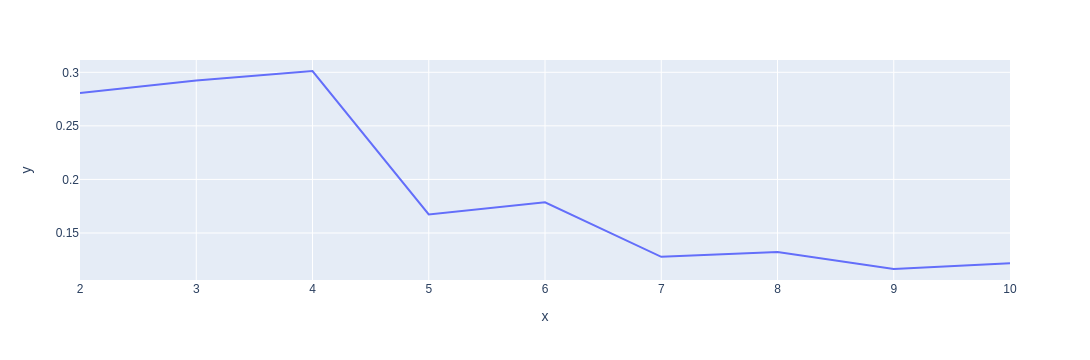

In [26]:
px.line(x=range(2,11),y=kmeans_score['Silhouette'])

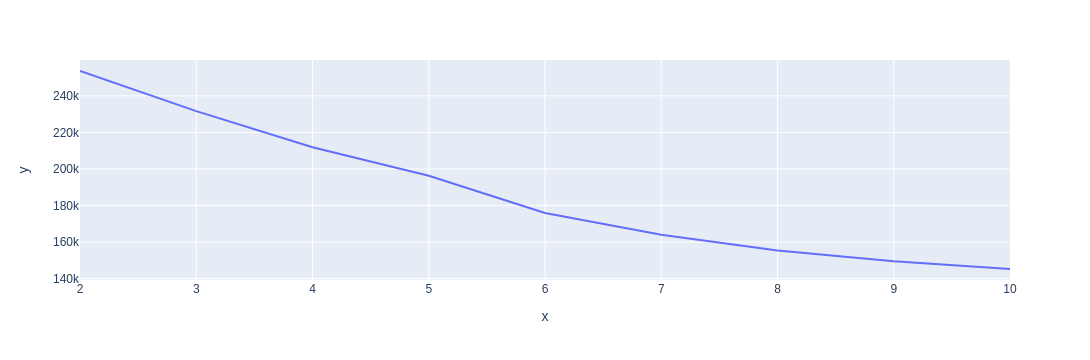

In [27]:
px.line(x=range(2,11),y=kmeans_score['SSE'])

#### Bisecting K-Means

In [28]:
%%time
from sklearn.cluster import BisectingKMeans

scores = []
for k in range(2,clusters+1):
    bisect_means = BisectingKMeans(n_clusters = k, random_state = r_state)
    bisect_means.fit(X_mat)
    preds = bisect_means.predict(X_mat)
    scores.append({'Clusters':k,
                  'SSE':bisect_means.inertia_,
                  'Silhouette':silhouette_score(X_mat,preds)})
bisect_scores = pd.DataFrame(scores)

CPU times: user 5min 1s, sys: 39.5 s, total: 5min 41s
Wall time: 5min 31s


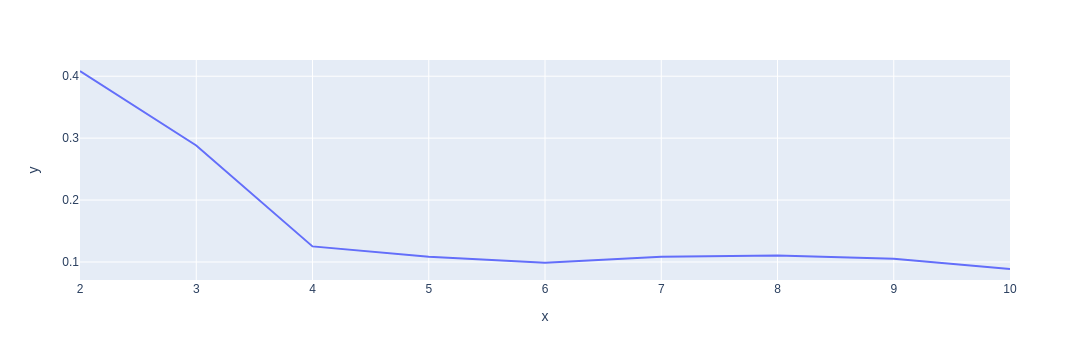

In [29]:
px.line(x=range(2,clusters+1),y=bisect_scores['Silhouette'])

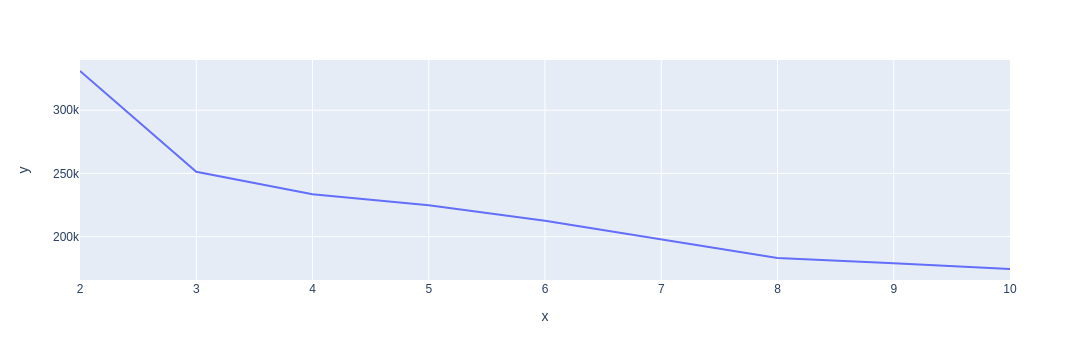

In [30]:
px.line(x=range(2,clusters+1),y=bisect_scores['SSE'])

#### Affinity Propagation

In [31]:
from sklearn.cluster import AffinityPropagation


#### DBSCAN

In [48]:
%%time
patch_sklearn()
from sklearn.cluster import DBSCAN

scores = []
metr = ['manhattan','euclidean']
epsi = [1.5,3.5,5.5]
mins = [5]
for k in epsi:
    for j in metr:
        for i in mins:
            dbscan = DBSCAN(n_jobs=-1,eps=k, metric=j)
            labels = dbscan.fit_predict(X_mat)
            scores.append({'metric':j,
                           'epsilon':k,
                           'min samples':i,
                           'Silhouette':silhouette_score(X_mat,labels),
                           'clusters':len(set(dbscan.labels_))-(1 if -1 in labels else 0)
                          })
dbscan_scores = pd.DataFrame(scores)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


CPU times: user 12min 39s, sys: 1min 29s, total: 14min 9s
Wall time: 5min 20s


In [49]:
dbscan_scores

metric  epsilon  min samples  Silhouette  clusters
0  manhattan      1.5            5   -0.350540       449
1  euclidean      1.5            5   -0.294827       140
2  manhattan      3.5            5   -0.226525        60
3  euclidean      3.5            5    0.549191         4
4  manhattan      5.5            5    0.218943        10
5  euclidean      5.5            5    0.645935         2

In [50]:
labels=dbscan.labels_
N_clus=len(set(labels))-(1 if -1 in labels else 0)
print('Estimated no. of clusters: %d' % N_clus)

Estimated no. of clusters: 2


#### Agglomerative Clustering

In [33]:
from sklearn.cluster import AgglomerativeClustering

### Modeling and Evaluation 2
(10 Points) Evaluate and Compare

### Modeling and Evaluation 3
(10 Points) Visualize Results

### Modeling and Evaluation 4
(20 Points) Summarize the rammifications

### Deployment
(10 Points)
Be critical of your performance and tell the reader how you current model might be usable by other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling? How useful is your model for interested parties (i.e., the companies or organizations that might want to use it)? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.?

### Exceptional Work
(10 Points) You have free reign to provide additional analyses or combine analyses